# Modelización de un clasificador

In [18]:
import pandas as pd
import numpy as np
import pickle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import wordpreproc as wp
import nltk




In [3]:
# Inicializamos preprocesamiento para futuras predicciones (wordpreproc.py)
new_prep = wp.WordPrep()
new_prep.update_stopwords()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Ejemplo de uso del preprocesado
new_prep.corpus_text_preprocessing("Hi there, this is a test, the concept of beauty")


'hi test concept beauty'

In [4]:
# Importamos los  datos
full_train = pd.read_csv("../data/processed/balanced_train.csv",index_col=0).reset_index(drop=True)
full_test = pd.read_csv("../data/processed/test.csv",index_col=0).reset_index(drop=True)
X_train = full_train.iloc[:,0]
y_train = full_train.iloc[:,-1]

X_test = full_test.iloc[:,0]
y_test = full_test.iloc[:,-1]
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(1200,) (1200,) (530,) (530,)


# Probando un modelo individual sin CV

In [46]:
# Multinomial Naive Bayes

my_targets = ['highschool','college','adult']
mnb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
mnb.fit(X_train,y_train)

y_pred = mnb.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_targets))


accuracy 0.9037735849056604
              precision    recall  f1-score   support

  highschool       0.85      0.89      0.87       176
     college       0.94      0.89      0.91       166
       adult       0.93      0.93      0.93       188

    accuracy                           0.90       530
   macro avg       0.91      0.90      0.90       530
weighted avg       0.91      0.90      0.90       530



[[157   6  13]
 [ 18 147   1]
 [  9   4 175]]


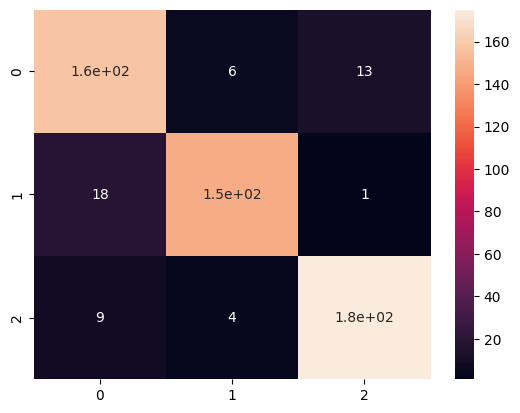

In [47]:
# Sacamos su matriz de confusión

c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)
import seaborn as sns
sns.heatmap(c_matrix, annot=True);

In [43]:
# Probamos a predecir nuevas frases

print("Kid try phrase: ",mnb.predict([new_prep.corpus_text_preprocessing("i dreamt of playing in a big playground")]))
print("Adolescent try: ",mnb.predict([new_prep.corpus_text_preprocessing("i love my career and friends here")]))
print("Adult try: ",mnb.predict([new_prep.corpus_text_preprocessing("i am a mother of 3 children")]))


Kid try phrase:  [0]
Adolescent try:  [1]
Adult try:  [2]


# Probando varios modelos

In [6]:
""""
MODELOS
"""
mulnb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])

regre_logi = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())
               ])

svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ("svm",SVC())
               ])

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier())
               ])

rand_forest = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())
               ])


"""
GRIDS
"""

mulnb_param = {
                "clf__alpha": [0.0,0.5,1.0]
                }


regre_logi_param = {    
                 "clf__penalty": ["l1","l2"], 
                 "clf__C": np.logspace(0, 4, 10)
                }


svm_param = {                    
            'svm__C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
            'svm__kernel': ["linear","poly","rbf"],
            'svm__coef0': [-10.,-1., 0., 0.1, 0.5, 1, 10, 100],
            'svm__gamma': ('scale', 'auto')
            }

sgd_param = {
            "clf__loss" : ["hinge","modified_huber"],
            "clf__penalty" : ['l2','l1'],
            "clf__alpha" : [1e-3,1e-2,1e-1,0.0]
            }


random_forest_param = {"clf__n_estimators": [120],
                     "clf__max_depth": [3,4,5,6,10,15,17],
                     "clf__max_features": ["sqrt", 3, 4]                          
                     }

In [75]:
modelos = [
         ('mulnb',mulnb,mulnb_param),
         ('regre_logi',regre_logi,regre_logi_param),
         ('svm', svm, svm_param),
         ('sgd',sgd,sgd_param),
         ('rand_forest', rand_forest, random_forest_param)]

models_gridsearch = {}

for i in modelos:
    models_gridsearch[i[0]] = GridSearchCV(i[1],
                                          i[2],
                                          cv=10,
                                          scoring="accuracy",
                                          verbose=1,
                                          n_jobs=-1)
    
    models_gridsearch[i[0]].fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Fitting 10 folds for each of 384 candidates, totalling 3840 fits
Fitting 10 folds for each of 16 candidates, totalling 160 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Fitting 10 folds for each of 21 candidates, totalling 210 fits


In [79]:
# Representamos los modelos y sus scores
best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]
best_grids = pd.DataFrame(best_grids, columns=["Modelo", "Mejor score en validación"]).sort_values(by="Mejor score en validación", ascending=False)
best_grids

,Modelo,Mejor score en validación
3,sgd,0.938333
1,regre_logi,0.937500
2,svm,0.935000
4,rand_forest,0.910833
0,mulnb,0.906667


In [90]:
# Scores en test
best_test = [(i, j.best_estimator_.score(X_test, y_test)) for i, j in models_gridsearch.items()]
best_test = pd.DataFrame(best_test, columns=["Modelo", "Mejor score en test"]).sort_values(by="Mejor score en test", ascending=False)
best_test

,Modelo,Mejor score en test
2,svm,0.945283
1,regre_logi,0.933962
3,sgd,0.933962
0,mulnb,0.907547
4,rand_forest,0.898113


In [80]:
# Mejor modelo
models_gridsearch['sgd'].best_estimator_

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(alpha=0.001, loss='modified_huber'))])

In [82]:
# Score en test
models_gridsearch['sgd'].best_estimator_.score(X_test, y_test)

0.9339622641509434

In [86]:
# Guardar el modelo
with open('../model/randomforest.model', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['rand_forest'].best_estimator_, archivo_salida)
with open('../model/modelofinalsgd.model', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['sgd'].best_estimator_, archivo_salida)
with open('../model/modelomulnb.model', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['mulnb'].best_estimator_, archivo_salida) 
with open('../model/modeloregrelogi.model', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['regre_logi'].best_estimator_, archivo_salida)   
with open('../model/modelosvm.model', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['svm'].best_estimator_, archivo_salida)

In [10]:
# Leer el modelo de nuevo
with open('../model/modelofinalsgd.model', "rb") as archivo_entrada:
    model_sgd = pickle.load(archivo_entrada)
with open('../model/modelosvm.model', "rb") as archivo_entrada:
    model_svm = pickle.load(archivo_entrada)
with open('../model/modelomulnb.model', "rb") as archivo_entrada:
    model_mulnb = pickle.load(archivo_entrada)
with open('../model/modeloregrelogi.model', "rb") as archivo_entrada:
    model_regrelogi = pickle.load(archivo_entrada)
with open('../model/randomforest.model', "rb") as archivo_entrada:
    model_randomfrest = pickle.load(archivo_entrada)    
    
print(model_randomfrest)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=17, n_estimators=120))])


In [12]:
# Clasificaciones de los modelos:

my_targets = ['highschool','college','adult']
modelos_class = [model_sgd,model_svm,model_mulnb,model_regrelogi]
for i in modelos_class:
    new_y_pred = i.predict(X_test)
    print("MODELO",i.steps[2][1].__class__.__name__,":")
    print('accuracy %s' % accuracy_score(new_y_pred, y_test))
    print(classification_report(y_test, new_y_pred,target_names=my_targets))


MODELO SGDClassifier :
accuracy 0.9339622641509434
              precision    recall  f1-score   support

  highschool       0.88      0.93      0.91       176
     college       1.00      0.90      0.95       166
       adult       0.93      0.97      0.95       188

    accuracy                           0.93       530
   macro avg       0.94      0.93      0.93       530
weighted avg       0.94      0.93      0.93       530

MODELO SVC :
accuracy 0.9452830188679245
              precision    recall  f1-score   support

  highschool       0.91      0.93      0.92       176
     college       1.00      0.92      0.96       166
       adult       0.93      0.98      0.96       188

    accuracy                           0.95       530
   macro avg       0.95      0.94      0.95       530
weighted avg       0.95      0.95      0.95       530

MODELO MultinomialNB :
accuracy 0.9075471698113208
              precision    recall  f1-score   support

  highschool       0.86      0.89      0

In [27]:
features = model_randomfrest[0].get_feature_names_out()

## Parece que el SGD y SVC tienen riesgo de overfitting (precision de 1.0), el multinomial NB parece el mejor candidato, y lo hemos mejorado con los nuevos parámetros

[[157   6  13]
 [ 17 148   1]
 [  8   4 176]]


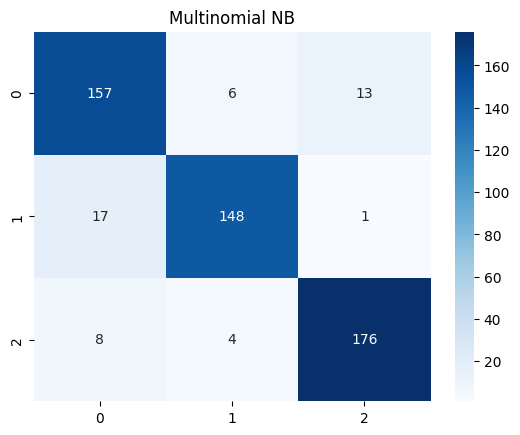

In [13]:
mulnb_pred = model_mulnb.predict(X_test)
c_matrix = confusion_matrix(y_test, mulnb_pred)
print(c_matrix)
import seaborn as sns
sns.heatmap(c_matrix, annot=True,fmt='g',cmap='Blues').set(title='Multinomial NB');

In [35]:
# feature importance con el random forest
importances = model_randomfrest[2].feature_importances_
forest_importances = pd.Series(importances, index=features)
forest_importances.sort_values(ascending=False).head(40)

interpretation    0.054172
answer            0.054089
question          0.048599
actual            0.035932
dream             0.029459
dreamt            0.016321
night             0.014319
really            0.012224
last              0.012215
none              0.011384
like              0.010592
seem              0.009407
wake              0.008526
say               0.008209
someone           0.007663
woke              0.007353
stuff             0.007288
girl              0.006998
unpleasant        0.006954
go                0.006454
participant       0.006015
pleasant          0.005546
woman             0.005471
think             0.005337
sue               0.005320
something         0.005138
mr                0.005045
fact              0.005011
remember          0.004826
kind              0.004624
get               0.004391
father            0.004200
mother            0.004107
anxious           0.004026
maybe             0.004022
large             0.003906
look              0.003744
f

# Podemos ver valores bajos de feature importance, nos podría indicar que no hay un sesgo/predisposicion abusiva por una palabras sobre otras en la clasificación, eso es positivo